In [30]:
%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib.dates as dates
import time
import numpy as np
import datetime as d
import pandas as pd
import os.path as path
import pytz

In [31]:
# List of instruments on WHOI string, SBE is a temp salinity sensor
# %  1 SBE37/1770.asc    10 m
# %  2 T3870/1T3870.DAT  20 m
# %  3 T3871/1T3871.DAT  25 m
# %  4 T3922/1T3922.DAT  30 m
# %  5 T3866/1T3866.DAT  35 m
# %  6 T3865/1T3865.DAT  40 m
# %  7 T3917/1T3917.DAT  45 m
# %  8 T3920/1T3920.DAT  50 m
# %  9 T3924/1T3924.DAT  55 m
# % 10 T3914/1T3914.DAT  60 m
# % 11 T3918/1T3918.DAT  65 m
# % 12 T3916/1T3916.DAT  70 m
# % 13 SBE37/4079.asc    75 m
# % 14 T3867/1T3867.DAT  80 m
# % 15 T3915/2T3915.DAT  85 m
# % 16 T3869/1T3869.DAT  90 m

In [32]:
#  read in starmon temp loggers
dataDir = '/Users/edwardlrichards/Documents/data/KAM11/enviornment/WHOI_Temp_String/TemperatureString'
saveName = '/Users/edwardlrichards/cir_processing/Enviornment/processedData/WHOI_Temp_String.pic'

seabirdName = ('1770', '4079')
seabirdFolder = 'SBE37'
seabirdDepths = np.array((10, 75))

starmonName = ('T3866','T3869','T3871','T3915','T3917',
                  'T3920','T3924','T3865','T3867','T3870','T3914','T3916',
                  'T3918','T3922')
starmonDepths = np.array((35, 90, 25, 85, 45, 50, 55, 40,
                   80, 20, 60, 70, 65, 30));

utc = pytz.utc
start_time = d.datetime(2011, 6, 24, 6, 0, 0, tzinfo=utc)
end_time = d.datetime(2011, 7, 11, 19, 45, 0, tzinfo=utc)
dtimeI = pd.date_range(start_time, end_time, freq='15s')
parseStarmon = lambda x: d.datetime.strptime(x, '%d.%m.%y %H:%M:%S')

In [33]:
def parseSeabird(day, tod):
    if isinstance(day, float):
        return None
    datetime = d.datetime.strptime(day + tod, ' %d %b %Y %H:%M:%S')
    return datetime

In [34]:
# Load both seabird and starmon data
# First is seabird
tempData = None

for name, depth in zip(seabirdName, seabirdDepths):
    loadString = path.join(dataDir, seabirdFolder, name + '.asc')
    columnNames = [depth, 'pressure', 'conductivity', 'day', 'tod']

    fileData = pd.read_csv(loadString, comment='*',
        parse_dates={'datetime': ['day','tod']},
        date_parser=parseSeabird, names=columnNames, index_col='datetime')
    
    fileData = fileData.ix[pd.notnull(fileData.index)]
    
    # Seabird 1770 dropped at some point.
    # This is clear in pressure record
    if name == '1770':
        cutoffTime = d.datetime.strptime('2011-07-03 11:54:30',\
                            '%Y-%m-%d %H:%M:%S')
        fileData.ix[cutoffTime:, depth] = np.nan
    del fileData['pressure']
    del fileData['conductivity']
    
    if tempData is None:
        tempData = fileData
    else:
        tempData = pd.merge(tempData, fileData, left_index=True,
                            right_index=True, how='outer')

In [35]:
_ = tempData[10].interpolate().plot()
# _ = plt.ylim(5,6)
# _ = plt.xlim(tempData.index[0], tempData.index[7.2e4])

In [36]:
# now load starmon data
for name, depth in zip(starmonName, starmonDepths):
    columnNames = ['index', 'datetime', depth]
    if name == 'T3915':
        loadString = path.join(dataDir, name, '2'+name+'.DAT')
    else:
        loadString = path.join(dataDir, name, '1'+name+'.DAT')
    fileData = pd.read_table(loadString, comment='#',
                             names = columnNames, date_parser=parseStarmon,
                             decimal=',',parse_dates=[1], index_col=1)
    
    # starmon loggers are exactly one hour fast
    del fileData['index']
    fileData.index = fileData.index.shift(-1, 'H')

    tempData = pd.merge(tempData, fileData, left_index=True,
                        right_index=True, how='outer')

In [37]:
centerTime = d.datetime(2011,6, 24, 23, 27)
plotTimeRange = d.timedelta(0,2 * 3600)
deploymentTime = tempData.ix[(centerTime - plotTimeRange):
                          (centerTime + plotTimeRange), :]

In [9]:
# Remove unrealistic readings
# Resample
tempData = tempData.resample('15S', how='mean')
#solrt columns by depth
columns = tempData.columns
columnIndex = np.argsort(columns)
tempData = tempData.iloc[:,columnIndex]
# Save load results
tempData.to_pickle(saveName)

In [29]:
deploymentTime[30].plot()

KeyError: 30

In [10]:
daysFmt = dates.DateFormatter("%j")
fig, ax = plt.subplots()
_ = ax.plot(tempData.index, tempData[65], '-')
_ = ax.xaxis.set_major_locator(dates.DayLocator())
_ = ax.xaxis.set_major_formatter(daysFmt)
_ = plt.ylim(20, 28)

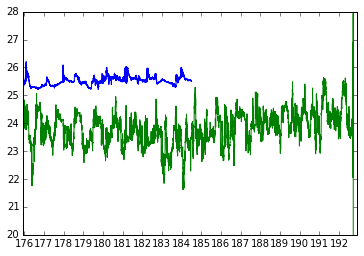

In [11]:
daysFmt = dates.DateFormatter("%j")
fig, ax = plt.subplots()
_ = ax.plot(tempData.index, tempData[10], '-')
_ = ax.plot(tempData.index, tempData[75], '-')
_ = ax.xaxis.set_major_locator(dates.DayLocator())
_ = ax.xaxis.set_major_formatter(daysFmt)
_ = plt.ylim(20, 28)